<a href="https://colab.research.google.com/github/jspark9703/nerf_study/blob/main/examples/vision/ipynb/nerf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3D volumetric rendering with NeRF

**Authors:** [Aritra Roy Gosthipaty](https://twitter.com/arig23498), [Ritwik Raha](https://twitter.com/ritwik_raha)<br>
**Date created:** 2021/08/09<br>
**Last modified:** 2023/11/13<br>
**Description:** Minimal implementation of volumetric rendering as shown in NeRF.

## Introduction

In this example, we present a minimal implementation of the research paper
[**NeRF: Representing Scenes as Neural Radiance Fields for View Synthesis**](https://arxiv.org/abs/2003.08934)
by Ben Mildenhall et. al. The authors have proposed an ingenious way
to *synthesize novel views of a scene* by modelling the *volumetric
scene function* through a neural network.

To help you understand this intuitively, let's start with the following question:
*would it be possible to give to a neural
network the position of a pixel in an image, and ask the network
to predict the color at that position?*

| ![2d-train](https://i.imgur.com/DQM92vN.png) |
| :---: |
| **Figure 1**: A neural network being given coordinates of an image
as input and asked to predict the color at the coordinates. |

The neural network would hypothetically *memorize* (overfit on) the
image. This means that our neural network would have encoded the entire image
in its weights. We could query the neural network with each position,
and it would eventually reconstruct the entire image.

| ![2d-test](https://i.imgur.com/6Qz5Hp1.png) |
| :---: |
| **Figure 2**: The trained neural network recreates the image from scratch. |

A question now arises, how do we extend this idea to learn a 3D
volumetric scene? Implementing a similar process as above would
require the knowledge of every voxel (volume pixel). Turns out, this
is quite a challenging task to do.

The authors of the paper propose a minimal and elegant way to learn a
3D scene using a few images of the scene. They discard the use of
voxels for training. The network learns to model the volumetric scene,
thus generating novel views (images) of the 3D scene that the model
was not shown at training time.

There are a few prerequisites one needs to understand to fully
appreciate the process. We structure the example in such a way that
you will have all the required knowledge before starting the
implementation.

## Setup

In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

# Setting random seed to obtain reproducible results.
import tensorflow as tf

tf.random.set_seed(42)

import keras
from keras import layers

import os
import glob
import imageio.v2 as imageio
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Initialize global variables.
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 5
NUM_SAMPLES = 32
POS_ENCODE_DIMS = 16
EPOCHS = 20

## Download and load the data

The `npz` data file contains images, camera poses, and a focal length.
The images are taken from multiple camera angles as shown in
**Figure 3**.

| ![camera-angles](https://i.imgur.com/FLsi2is.png) |
| :---: |
| **Figure 3**: Multiple camera angles <br>
[Source: NeRF](https://arxiv.org/abs/2003.08934) |


To understand camera poses in this context we have to first allow
ourselves to think that a *camera is a mapping between the real-world
and the 2-D image*.

| ![mapping](https://www.mathworks.com/help/vision/ug/calibration_coordinate_blocks.png) |
| :---: |
| **Figure 4**: 3-D world to 2-D image mapping through a camera <br>
[Source: Mathworks](https://www.mathworks.com/help/vision/ug/camera-calibration.html) |

Consider the following equation:

<img src="https://i.imgur.com/TQHKx5v.pngg" width="100" height="50"/>

Where **x** is the 2-D image point, **X** is the 3-D world point and
**P** is the camera-matrix. **P** is a 3 x 4 matrix that plays the
crucial role of mapping the real world object onto an image plane.

<img src="https://i.imgur.com/chvJct5.png" width="300" height="100"/>

The camera-matrix is an *affine transform matrix* that is
concatenated with a 3 x 1 column `[image height, image width, focal length]`
to produce the *pose matrix*. This matrix is of
dimensions 3 x 5 where the first 3 x 3 block is in the camera’s point
of view. The axes are `[down, right, backwards]` or `[-y, x, z]`
where the camera is facing forwards `-z`.

| ![camera-mapping](https://i.imgur.com/kvjqbiO.png) |
| :---: |
| **Figure 5**: The affine transformation. |

The COLMAP frame is `[right, down, forwards]` or `[x, -y, -z]`. Read
more about COLMAP [here](https://colmap.github.io/).

12727482/12727482 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


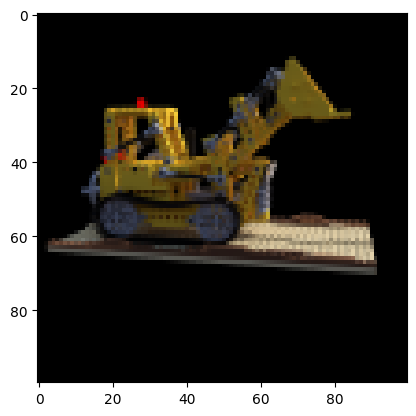

In [2]:
# Download the data if it does not already exist.
url = (
    "http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz"
)
data = keras.utils.get_file(origin=url)

data = np.load(data)
images = data["images"]
im_shape = images.shape
(num_images, H, W, _) = images.shape
(poses, focal) = (data["poses"], data["focal"])

# Plot a random image from the dataset for visualization.
plt.imshow(images[np.random.randint(low=0, high=num_images)])
plt.show()

In [3]:
for key in data.files:
    print(f"- {key}: shape={data[key].shape}, dtype={data[key].dtype}")

- images: shape=(106, 100, 100, 3), dtype=float32
- poses: shape=(106, 4, 4), dtype=float32
- focal: shape=(), dtype=float64


In [4]:
print("예시 이미지 픽셀 값:", images[0, 0, 0])  # 첫 이미지 왼쪽 위 픽셀
print("예시 카메라 포즈:\n", poses[0])          # 첫 이미지의 카메라 포즈
print("초점 거리 값:", focal)                   # 초점 거리 값


예시 이미지 픽셀 값: [0. 0. 0.]
예시 카메라 포즈:
 [[-9.9990219e-01  4.1922452e-03 -1.3345719e-02 -5.3798322e-02]
 [-1.3988681e-02 -2.9965907e-01  9.5394367e-01  3.8454704e+00]
 [-4.6566129e-10  9.5403719e-01  2.9968831e-01  1.2080823e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]
초점 거리 값: 138.88887889922103


## Data pipeline

Now that you've understood the notion of camera matrix
and the mapping from a 3D scene to 2D images,
let's talk about the inverse mapping, i.e. from 2D image to the 3D scene.

We'll need to talk about volumetric rendering with ray casting and tracing,
which are common computer graphics techniques.
This section will help you get to speed with these techniques.

Consider an image with `N` pixels. We shoot a ray through each pixel
and sample some points on the ray. A ray is commonly parameterized by
the equation `r(t) = o + td` where `t` is the parameter, `o` is the
origin and `d` is the unit directional vector as shown in **Figure 6**.

| ![img](https://i.imgur.com/ywrqlzt.gif) |
| :---: |
| **Figure 6**: `r(t) = o + td` where t is 3 |

In **Figure 7**, we consider a ray, and we sample some random points on
the ray. These sample points each have a unique location `(x, y, z)`
and the ray has a viewing angle `(theta, phi)`. The viewing angle is
particularly interesting as we can shoot a ray through a single pixel
in a lot of different ways, each with a unique viewing angle. Another
interesting thing to notice here is the noise that is added to the
sampling process. We add a uniform noise to each sample so that the
samples correspond to a continuous distribution. In **Figure 7** the
blue points are the evenly distributed samples and the white points
`(t1, t2, t3)` are randomly placed between the samples.

| ![img](https://i.imgur.com/r9TS2wv.gif) |
| :---: |
| **Figure 7**: Sampling the points from a ray. |

**Figure 8** showcases the entire sampling process in 3D, where you
can see the rays coming out of the white image. This means that each
pixel will have its corresponding rays and each ray will be sampled at
distinct points.

| ![3-d rays](https://i.imgur.com/hr4D2g2.gif) |
| :---: |
| **Figure 8**: Shooting rays from all the pixels of an image in 3-D |

These sampled points act as the input to the NeRF model. The model is
then asked to predict the RGB color and the volume density at that
point.

| ![3-Drender](https://i.imgur.com/HHb6tlQ.png) |
| :---: |
| **Figure 9**: Data pipeline <br>
[Source: NeRF](https://arxiv.org/abs/2003.08934) |

In [7]:

def encode_position(x):
    """Encodes the position into its corresponding Fourier feature.

    Args:
        x: The input coordinate.

    Returns:
        Fourier features tensors of the position.
    """
    positions = [x]
    for i in range(POS_ENCODE_DIMS):
        for fn in [tf.sin, tf.cos]:
            positions.append(fn(2.0**i * x))
    return tf.concat(positions, axis=-1)


def get_rays(height, width, focal, pose):
    """Computes origin point and direction vector of rays.

    Args:
        height: Height of the image.
        width: Width of the image.
        focal: The focal length between the images and the camera.
        pose: The pose matrix of the camera.

    Returns:
        Tuple of origin point and direction vector for rays.
    """
    # Build a meshgrid for the rays.
    i, j = tf.meshgrid(
        tf.range(width, dtype=tf.float32),
        tf.range(height, dtype=tf.float32),
        indexing="xy",
    )

    # Normalize the x axis coordinates.
    transformed_i = (i - width * 0.5) / focal

    # Normalize the y axis coordinates.
    transformed_j = (j - height * 0.5) / focal

    # Create the direction unit vectors.
    directions = tf.stack([transformed_i, -transformed_j, -tf.ones_like(i)], axis=-1)

    # Get the camera matrix.
    camera_matrix = pose[:3, :3]
    height_width_focal = pose[:3, -1]

    # Get origins and directions for the rays.
    transformed_dirs = directions[..., None, :]
    camera_dirs = transformed_dirs * camera_matrix
    ray_directions = tf.reduce_sum(camera_dirs, axis=-1)
    ray_origins = tf.broadcast_to(height_width_focal, tf.shape(ray_directions))

    # Return the origins and directions.
    return (ray_origins, ray_directions)


def render_flat_rays(ray_origins, ray_directions, near, far, num_samples, rand=False):
    t_vals = tf.linspace(near, far, num_samples)
    if rand:
        shape = list(ray_origins.shape[:-1]) + [num_samples]
        noise = tf.random.uniform(shape=shape) * (far - near) / num_samples
        t_vals = t_vals + noise

    rays = ray_origins[..., None, :] + ray_directions[..., None, :] * t_vals[..., None]
    rays_flat = tf.reshape(rays, [-1, 3])

    # 각 샘플에 맞게 direction도 broadcast
    directions = tf.broadcast_to(ray_directions[..., None, :], shape=rays.shape)
    directions_flat = tf.reshape(directions, [-1, 3])

    return rays_flat, directions_flat, t_vals


def map_fn(pose):
    ray_origins, ray_directions = get_rays(height=H, width=W, focal=focal, pose=pose)
    rays_flat, dirs_flat, t_vals = render_flat_rays(
        ray_origins=ray_origins,
        ray_directions=ray_directions,
        near=2.0,
        far=6.0,
        num_samples=NUM_SAMPLES,
        rand=True,
    )
    return (ray_origins, ray_directions, t_vals)



# Create the training split.
split_index = int(num_images * 0.8)

# Split the images into training and validation.
train_images = images[:split_index]
val_images = images[split_index:]

# Split the poses into training and validation.
train_poses = poses[:split_index]
val_poses = poses[split_index:]

# Make the training pipeline.
train_img_ds = tf.data.Dataset.from_tensor_slices(train_images)
train_pose_ds = tf.data.Dataset.from_tensor_slices(train_poses)
train_ray_ds = train_pose_ds.map(map_fn, num_parallel_calls=AUTO)
training_ds = tf.data.Dataset.zip((train_img_ds, train_ray_ds))
train_ds = (
    training_ds.shuffle(BATCH_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True, num_parallel_calls=AUTO)
    .prefetch(AUTO)
)

# Make the validation pipeline.
val_img_ds = tf.data.Dataset.from_tensor_slices(val_images)
val_pose_ds = tf.data.Dataset.from_tensor_slices(val_poses)
val_ray_ds = val_pose_ds.map(map_fn, num_parallel_calls=AUTO)
validation_ds = tf.data.Dataset.zip((val_img_ds, val_ray_ds))
val_ds = (
    validation_ds.shuffle(BATCH_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True, num_parallel_calls=AUTO)
    .prefetch(AUTO)
)

In [9]:
for images_batch, (ray_origins, ray_directions, t_vals_batch) in train_ds.take(1):
    print("✅ 이미지 배치")
    print("images_batch.shape:", images_batch.shape)

    print("\n✅ 광선 원점 (ray origins)")
    print("ray_origins.shape:", ray_origins.shape)

    print("\n✅ 광선 방향 (ray directions)")
    print("ray_directions.shape:", ray_directions.shape)

    print("\n✅ 각 샘플 포인트의 깊이 값 (t_vals)")
    print("t_vals_batch.shape:", t_vals_batch.shape)


✅ 이미지 배치
images_batch.shape: (5, 100, 100, 3)

✅ 광선 원점 (ray origins)
ray_origins.shape: (5, 100, 100, 3)

✅ 광선 방향 (ray directions)
ray_directions.shape: (5, 100, 100, 3)

✅ 각 샘플 포인트의 깊이 값 (t_vals)
t_vals_batch.shape: (5, 100, 100, 32)


## NeRF model

The model is a multi-layer perceptron (MLP), with ReLU as its non-linearity.

An excerpt from the paper:

*"We encourage the representation to be multiview-consistent by
restricting the network to predict the volume density sigma as a
function of only the location `x`, while allowing the RGB color `c` to be
predicted as a function of both location and viewing direction. To
accomplish this, the MLP first processes the input 3D coordinate `x`
with 8 fully-connected layers (using ReLU activations and 256 channels
per layer), and outputs sigma and a 256-dimensional feature vector.
This feature vector is then concatenated with the camera ray's viewing
direction and passed to one additional fully-connected layer (using a
ReLU activation and 128 channels) that output the view-dependent RGB
color."*

Here we have gone for a minimal implementation and have used 64
Dense units instead of 256 as mentioned in the paper.

In [17]:

def get_nerf_model(num_layers=8, num_pos=None):
    """Accurate NeRF MLP with residual connection and full separation between σ and RGB heads."""
    pos_input = keras.Input(shape=(2 * 3 * POS_ENCODE_DIMS + 3))  # encoded (x, y, z)
    dir_input = keras.Input(shape=(2 * 3 * POS_ENCODE_DIMS + 3))  # encoded viewing dir

    # ----------- Position encoding pathway (8 layers + skip) -----------
    x = pos_input
    for i in range(8):
        x = layers.Dense(256, activation="relu")(x)
        if i == 4:
            x = layers.concatenate([x, pos_input])

    # ----------- Sigma (Density) head -----------
    sigma = layers.Dense(1)(x)  # No activation here — will be relu’d later

    # ----------- Feature vector to RGB path -----------
    feature = layers.Dense(256, activation="relu")(x)  # bottleneck feature
    h = layers.concatenate([feature, dir_input])  # concat with encoded dir
    h = layers.Dense(128, activation="relu")(h)
    rgb = layers.Dense(3, activation="sigmoid")(h)  # sigmoid for [0,1] RGB

    # ----------- Final output -----------
    output = layers.concatenate([rgb, sigma], axis=-1)  # shape: (batch, 4)
    return keras.Model(inputs=[pos_input, dir_input], outputs=output)

def render_rgb_depth(model, rays_flat, directions_flat, t_vals, rand=True, train=True):
    encoded_pos = encode_position(rays_flat)
    encoded_dir = encode_position(directions_flat)

    model_input = [encoded_pos, encoded_dir]

    if train:
        predictions = model(model_input)
    else:
        predictions = model.predict(model_input)

    predictions = tf.reshape(predictions, shape=(BATCH_SIZE, H, W, NUM_SAMPLES, 4))
    rgb = tf.sigmoid(predictions[..., :-1])
    sigma_a = tf.nn.relu(predictions[..., -1])

    delta = t_vals[..., 1:] - t_vals[..., :-1]
    delta = tf.concat(
        [delta, tf.broadcast_to([1e10], shape=(BATCH_SIZE, H, W, 1))], axis=-1
    )

    alpha = 1.0 - tf.exp(-sigma_a * delta)
    transmittance = tf.math.cumprod(1.0 - alpha + 1e-10, axis=-1, exclusive=True)
    weights = alpha * transmittance

    rgb_map = tf.reduce_sum(weights[..., None] * rgb, axis=-2)
    depth_map = tf.reduce_sum(weights * t_vals, axis=-1)
    return rgb_map, depth_map


## Training

The training step is implemented as part of a custom `keras.Model` subclass
so that we can make use of the `model.fit` functionality.

In [18]:

class NeRF(keras.Model):
    def __init__(self, coarse_model, fine_model, num_fine):
        super().__init__()
        self.coarse_model = coarse_model
        self.fine_model = fine_model
        self.num_fine = num_fine

    def compile(self, optimizer, loss_fn):
        super().compile()
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.psnr_tracker = keras.metrics.Mean(name="psnr")

    def train_step(self, inputs):
        images, rays = inputs
        rays_o, rays_d, t_vals = rays  # outputs of render_flat_rays()

        with tf.GradientTape() as tape:
            rgb_coarse, rgb_fine = render_nerf_dual(
                coarse_model=self.coarse_model,
                fine_model=self.fine_model,
                rays_o=rays_o,
                rays_d=rays_d,
                t_vals=t_vals,
                num_fine=self.num_fine,
                rand=True
            )

            # Compute losses
            loss_coarse = self.loss_fn(images, rgb_coarse)
            loss_fine = self.loss_fn(images, rgb_fine)
            loss = loss_coarse + loss_fine

        variables = self.coarse_model.trainable_variables + self.fine_model.trainable_variables
        grads = tape.gradient(loss, variables)
        self.optimizer.apply_gradients(zip(grads, variables))

        psnr = tf.image.psnr(images, rgb_fine, max_val=1.0)
        self.loss_tracker.update_state(loss)
        self.psnr_tracker.update_state(psnr)
        return {"loss": self.loss_tracker.result(), "psnr": self.psnr_tracker.result()}

    def test_step(self, inputs):
        images, rays = inputs
        rays_o, rays_d, t_vals = rays
        test_rgb_c, test_rgb_f = render_nerf_dual(
            coarse_model=coarse_model,
            fine_model=fine_model,
            rays_o=rays_o,
            rays_d=rays_d,
            t_vals=test_t_vals,
            num_fine=128,
            rand=False
        )
        loss_coarse = self.loss_fn(images, test_rgb_c)
        loss_fine = self.loss_fn(images, test_rgb_f)
        loss = loss_coarse + loss_fine
        psnr = tf.image.psnr(images, test_rgb_f, max_val=1.0)

        self.loss_tracker.update_state(loss)
        self.psnr_tracker.update_state(psnr)
        return {"loss": self.loss_tracker.result(), "psnr": self.psnr_tracker.result()}

    @property
    def metrics(self):
        return [self.loss_tracker, self.psnr_tracker]

test_imgs, test_rays = next(iter(train_ds))
rays_o, rays_d, test_t_vals = test_rays

loss_list = []


class TrainMonitor(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        loss = logs["loss"]
        loss_list.append(loss)
        test_recons_images, depth_maps = render_rgb_depth(
            model=self.model.nerf_model,
            rays_flat=test_rays_flat,
            t_vals=test_t_vals,
            rand=True,
            train=False,
        )

        # Plot the rgb, depth and the loss plot.
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
        ax[0].imshow(keras.utils.array_to_img(test_recons_images[0]))
        ax[0].set_title(f"Predicted Image: {epoch:03d}")

        ax[1].imshow(keras.utils.array_to_img(depth_maps[0, ..., None]))
        ax[1].set_title(f"Depth Map: {epoch:03d}")

        ax[2].plot(loss_list)
        ax[2].set_xticks(np.arange(0, EPOCHS + 1, 5.0))
        ax[2].set_title(f"Loss Plot: {epoch:03d}")

        fig.savefig(f"images/{epoch:03d}.png")
        plt.show()
        plt.close()


num_pos = H * W * NUM_SAMPLES
coarse_model =  get_nerf_model(num_layers=8, num_pos=num_pos)
fine_model =  get_nerf_model(num_layers=8, num_pos=num_pos)

def sample_pdf(bins, weights, num_fine_samples, det=False):
    weights += 1e-5  # prevent nans
    pdf = weights / tf.reduce_sum(weights, axis=-1, keepdims=True)
    cdf = tf.cumsum(pdf, axis=-1)
    cdf = tf.concat([tf.zeros_like(cdf[..., :1]), cdf], axis=-1)

    if det:
        u = tf.linspace(0., 1., num_fine_samples)
        u = tf.broadcast_to(u, tf.shape(cdf[..., 1:]))
    else:
        u = tf.random.uniform(tf.shape(cdf[..., 1:]), dtype=pdf.dtype)

    u = tf.sort(u, axis=-1)

    inds = tf.searchsorted(cdf, u, side='right')
    below = tf.maximum(0, inds - 1)
    above = tf.minimum(cdf.shape[-1] - 1, inds)

    inds_sampled = tf.stack([below, above], axis=-1)
    matched_shape = [inds_sampled.shape[0], inds_sampled.shape[1], cdf.shape[-1]]
    cdf_g = tf.gather(cdf, inds_sampled, axis=-1, batch_dims=1)
    bins_g = tf.gather(bins, inds_sampled, axis=-1, batch_dims=1)

    denom = cdf_g[..., 1] - cdf_g[..., 0]
    denom = tf.where(denom < 1e-5, tf.ones_like(denom), denom)
    t = (u - cdf_g[..., 0]) / denom
    samples = bins_g[..., 0] + t * (bins_g[..., 1] - bins_g[..., 0])
    return samples

def hierarchical_sample(ray_origins, ray_directions, t_vals_coarse, weights_coarse, num_fine):
    mid = 0.5 * (t_vals_coarse[..., :-1] + t_vals_coarse[..., 1:])
    fine_t_vals = sample_pdf(mid, weights_coarse[..., 1:-1], num_fine)

    t_vals_all = tf.sort(tf.concat([t_vals_coarse, fine_t_vals], axis=-1), axis=-1)

    # r(t) = o + td
    sample_points = ray_origins[..., None, :] + ray_directions[..., None, :] * t_vals_all[..., None]
    directions = tf.broadcast_to(ray_directions[..., None, :], sample_points.shape)
    points_flat = tf.reshape(sample_points, [-1, 3])
    dirs_flat = tf.reshape(directions, [-1, 3])

    return points_flat, dirs_flat, t_vals_all

def render_nerf_dual(coarse_model, fine_model, rays_o, rays_d, t_vals, num_fine, rand=True):
    # 1. Coarse
    pts = rays_o[..., None, :] + rays_d[..., None, :] * t_vals[..., None]
    dirs = tf.broadcast_to(rays_d[..., None, :], pts.shape)
    pts_flat = tf.reshape(pts, [-1, 3])
    dirs_flat = tf.reshape(dirs, [-1, 3])

    encoded_pts = encode_position(pts_flat)
    encoded_dirs = encode_position(dirs_flat)
    preds = coarse_model([encoded_pts, encoded_dirs])
    preds = tf.reshape(preds, (*t_vals.shape, 4))
    rgb_c, sigma_c = preds[..., :-1], tf.nn.relu(preds[..., -1])

    # 2. Rendering coarse
    delta = t_vals[..., 1:] - t_vals[..., :-1]
    delta = tf.concat([delta, tf.broadcast_to([1e10], tf.shape(delta[..., :1]))], axis=-1)
    alpha = 1.0 - tf.exp(-sigma_c * delta)
    T = tf.math.cumprod(1.0 - alpha + 1e-10, axis=-1, exclusive=True)
    weights = alpha * T
    rgb_map_coarse = tf.reduce_sum(weights[..., None] * tf.sigmoid(rgb_c), axis=-2)

    # 3. Fine sampling
    pts_fine_flat, dirs_fine_flat, t_vals_fine = hierarchical_sample(
        rays_o, rays_d, t_vals, weights, num_fine
    )
    encoded_pts_f = encode_position(pts_fine_flat)
    encoded_dirs_f = encode_position(dirs_fine_flat)
    preds_f = fine_model([encoded_pts_f, encoded_dirs_f])
    preds_f = tf.reshape(preds_f, (*t_vals_fine.shape, 4))
    rgb_f, sigma_f = preds_f[..., :-1], tf.nn.relu(preds_f[..., -1])

    # 4. Rendering fine
    delta_f = t_vals_fine[..., 1:] - t_vals_fine[..., :-1]
    delta_f = tf.concat([delta_f, tf.broadcast_to([1e10], tf.shape(delta_f[..., :1]))], axis=-1)
    alpha_f = 1.0 - tf.exp(-sigma_f * delta_f)
    T_f = tf.math.cumprod(1.0 - alpha_f + 1e-10, axis=-1, exclusive=True)
    weights_f = alpha_f * T_f
    rgb_map_fine = tf.reduce_sum(weights_f[..., None] * tf.sigmoid(rgb_f), axis=-2)

    return rgb_map_coarse, rgb_map_fine

model = NeRF(coarse_model, fine_model, num_fine=128)
model.compile(
   optimizer=keras.optimizers.Adam(5e-4),
    loss_fn=keras.losses.MeanSquaredError())

# Create a directory to save the images during training.
if not os.path.exists("images"):
    os.makedirs("images")



model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=[TrainMonitor()])

def create_gif(path_to_images, name_gif):
    filenames = glob.glob(path_to_images)
    filenames = sorted(filenames)
    images = []
    for filename in tqdm(filenames):
        images.append(imageio.imread(filename))
    kargs = {"duration": 0.25}
    imageio.mimsave(name_gif, images, "GIF", **kargs)


create_gif("images/*.png", "training.gif")

ValueError: Cannot convert '99' to a shape.

## Visualize the training step

Here we see the training step. With the decreasing loss, the rendered
image and the depth maps are getting better. In your local system, you
will see the `training.gif` file generated.

![training-20](https://i.imgur.com/ql5OcYA.gif)

## Inference

In this section, we ask the model to build novel views of the scene.
The model was given `106` views of the scene in the training step. The
collections of training images cannot contain each and every angle of
the scene. A trained model can represent the entire 3-D scene with a
sparse set of training images.

Here we provide different poses to the model and ask for it to give us
the 2-D image corresponding to that camera view. If we infer the model
for all the 360-degree views, it should provide an overview of the
entire scenery from all around.

In [ ]:
# Get the trained NeRF model and infer.
nerf_model = model.nerf_model
test_recons_images, depth_maps = render_rgb_depth(
    model=self.model,
    rays_flat=test_rays_flat,
    t_vals=test_t_vals,
    rand=True,
    train=False,
)
# Create subplots.
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(10, 20))

for ax, ori_img, recons_img, depth_map in zip(
    axes, test_imgs, test_recons_images, depth_maps
):
    ax[0].imshow(keras.utils.array_to_img(ori_img))
    ax[0].set_title("Original")

    ax[1].imshow(keras.utils.array_to_img(recons_img))
    ax[1].set_title("Reconstructed")

    ax[2].imshow(keras.utils.array_to_img(depth_map[..., None]), cmap="inferno")
    ax[2].set_title("Depth Map")

## Render 3D Scene

Here we will synthesize novel 3D views and stitch all of them together
to render a video encompassing the 360-degree view.

In [ ]:

def get_translation_t(t):
    """Get the translation matrix for movement in t."""
    matrix = [
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, t],
        [0, 0, 0, 1],
    ]
    return tf.convert_to_tensor(matrix, dtype=tf.float32)


def get_rotation_phi(phi):
    """Get the rotation matrix for movement in phi."""
    matrix = [
        [1, 0, 0, 0],
        [0, tf.cos(phi), -tf.sin(phi), 0],
        [0, tf.sin(phi), tf.cos(phi), 0],
        [0, 0, 0, 1],
    ]
    return tf.convert_to_tensor(matrix, dtype=tf.float32)


def get_rotation_theta(theta):
    """Get the rotation matrix for movement in theta."""
    matrix = [
        [tf.cos(theta), 0, -tf.sin(theta), 0],
        [0, 1, 0, 0],
        [tf.sin(theta), 0, tf.cos(theta), 0],
        [0, 0, 0, 1],
    ]
    return tf.convert_to_tensor(matrix, dtype=tf.float32)


def pose_spherical(theta, phi, t):
    """
    Get the camera to world matrix for the corresponding theta, phi
    and t.
    """
    c2w = get_translation_t(t)
    c2w = get_rotation_phi(phi / 180.0 * np.pi) @ c2w
    c2w = get_rotation_theta(theta / 180.0 * np.pi) @ c2w
    c2w = np.array([[-1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1]]) @ c2w
    return c2w


rgb_frames = []
batch_flat = []
batch_t = []

# Iterate over different theta value and generate scenes.
for index, theta in tqdm(enumerate(np.linspace(0.0, 360.0, 120, endpoint=False))):
    # Get the camera to world matrix.
    c2w = pose_spherical(theta, -30.0, 4.0)

    #
    ray_oris, ray_dirs = get_rays(H, W, focal, c2w)
    rays_flat, t_vals = render_flat_rays(
        ray_oris, ray_dirs, near=2.0, far=6.0, num_samples=NUM_SAMPLES, rand=False
    )

    if index % BATCH_SIZE == 0 and index > 0:
        batched_flat = tf.stack(batch_flat, axis=0)
        batch_flat = [rays_flat]

        batched_t = tf.stack(batch_t, axis=0)
        batch_t = [t_vals]

        rgb, _ = render_rgb_depth(
            nerf_model, batched_flat, batched_t, rand=False, train=False
        )

        temp_rgb = [np.clip(255 * img, 0.0, 255.0).astype(np.uint8) for img in rgb]

        rgb_frames = rgb_frames + temp_rgb
    else:
        batch_flat.append(rays_flat)
        batch_t.append(t_vals)

rgb_video = "rgb_video.mp4"
imageio.mimwrite(rgb_video, rgb_frames, fps=30, quality=7, macro_block_size=None)

### Visualize the video

Here we can see the rendered 360 degree view of the scene. The model
has successfully learned the entire volumetric space through the
sparse set of images in **only 20 epochs**. You can view the
rendered video saved locally, named `rgb_video.mp4`.

![rendered-video](https://i.imgur.com/j2sIkzW.gif)

## Conclusion

We have produced a minimal implementation of NeRF to provide an intuition of its
core ideas and methodology. This method has been used in various
other works in the computer graphics space.

We would like to encourage our readers to use this code as an example
and play with the hyperparameters and visualize the outputs. Below we
have also provided the outputs of the model trained for more epochs.

| Epochs | GIF of the training step |
| :--- | :---: |
| **100** | ![100-epoch-training](https://i.imgur.com/2k9p8ez.gif) |
| **200** | ![200-epoch-training](https://i.imgur.com/l3rG4HQ.gif) |

## Way forward

If anyone is interested to go deeper into NeRF, we have built a 3-part blog
series at [PyImageSearch](https://pyimagesearch.com/).

- [Prerequisites of NeRF](https://www.pyimagesearch.com/2021/11/10/computer-graphics-and-deep-learning-with-nerf-using-tensorflow-and-keras-part-1/)
- [Concepts of NeRF](https://www.pyimagesearch.com/2021/11/17/computer-graphics-and-deep-learning-with-nerf-using-tensorflow-and-keras-part-2/)
- [Implementing NeRF](https://www.pyimagesearch.com/2021/11/24/computer-graphics-and-deep-learning-with-nerf-using-tensorflow-and-keras-part-3/)

## Reference

- [NeRF repository](https://github.com/bmild/nerf): The official
    repository for NeRF.
- [NeRF paper](https://arxiv.org/abs/2003.08934): The paper on NeRF.
- [Manim Repository](https://github.com/3b1b/manim): We have used
    manim to build all the animations.
- [Mathworks](https://www.mathworks.com/help/vision/ug/camera-calibration.html):
    Mathworks for the camera calibration article.
- [Mathew's video](https://www.youtube.com/watch?v=dPWLybp4LL0): A
    great video on NeRF.

You can try the model on [Hugging Face Spaces](https://huggingface.co/spaces/keras-io/NeRF).